# Explortatory analysis 

Notebook for exploratory analysis on tetrode data in the mPFC of a rat doing the parametric working memory (PWM) task.

Session: `data_sdc_20190902_145404_fromSD`

Current data storage:
* raw .dat, .rec, .mda, .bin and preprocessed .bin files are located on scratch under ``

* sorted data is located on bucket `Y:\jbreda\ephys\post_sort_analysis\sorted_pre_bdata`

* in a sorted folder: 
    * folder for each .bin bundle & cluster notes, matlab struct w/ spike info from scraped phy, matlab struct w/ behavior info scraped from bdata
    * in .bin bundle folder you will find curated kilosort output, mask info as npy and preprocessed .bin that was run

see [jbreda_PWM_ephys_analysis](https://github.com/Brody-Lab/jbreda_PWM_ephys_analysis) for more info on how this info was obtained


**TODO**
* deal w/ zeroing info
* figure out how to get spk waveform with new dict structure
* plotting iterations



## Libs & fxs

In [1]:
# settings

%load_ext autoreload
%autoreload 2

# libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import scipy.io as spio
import os
from spykes.spykes.plot.neurovis import NeuroVis
from utils import *

sns.set_context("talk")

## I/O & Wrangle

In [2]:
# global
dir_name  = 'Y:\jbreda\ephys\post_sort_analysis\sorted_pre_bdata' 
beh_mat   = 'protocol_info.mat'
spks_mat  = 'ksphy_clusters_foranalysis.mat'
sess_name = 'data_sdc_20190902_145404_fromSD'
sess_dir = os.path.join(dir_name, sess_name)

# create paths
beh_path  = os.path.join(dir_name, sess_name, beh_mat)
spks_path = os.path.join(dir_name, sess_name, spks_mat)

# load & wrangle
beh_df, spks_dict = load_and_wrangle(beh_path, spks_path, overwrite=False)

# get neurons into NeuroVis objects
neurons = initiate_neurons(spks_dict, "20190902")

"""Loading & saving info for later"""
# # beh_df.to_csv(os.path.join(dir_name, sess_name, 'beh_df.csv'), index=False)

# # preloading spks_dict
# import pickle

# f = open(os.path.join(dir_name, sess_name, 'spks_dict.pkl'),"wb")
# pickle.dump(spks_dict,f)
# f.close()

# f= open(os.path.join(dir_name, sess_name, 'spks_dict.pkl'), "rb")
# loaded_dictionary = pickle.load(f)

'Loading & saving info for later'

In [3]:
beh_df

,hit_hist,delay,pair_hist,correct_side,prev_side,aud1_sigma,aud2_sigma,c_poke,end_state,hit_state,aud1_on,aud1_off,aud2_on,aud2_off
0,viol,6,9,RIGHT,NaN,0.008904,0.007300,476.563229,478.330221,NaN,NaN,NaN,NaN,NaN
1,viol,4,4,RIGHT,RIGHT,0.053144,0.019683,479.869221,481.457220,NaN,NaN,NaN,NaN,NaN
2,hit,6,3,RIGHT,RIGHT,0.019683,0.007290,482.048223,491.384224,490.309221,482.098232,482.498223,488.499224,488.898223
3,miss,2,9,RIGHT,RIGHT,0.008904,0.007300,498.909227,504.188223,502.903229,498.960232,499.360221,501.359229,501.759230
4,hit,2,6,LEFT,RIGHT,0.002700,0.007290,505.471227,510.643223,509.341221,505.522228,505.922229,507.922222,508.321227
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
400,hit,2,2,RIGHT,LEFT,0.007290,0.002700,5227.210220,5232.558223,5231.212228,5227.260225,5227.660226,5229.661221,5230.061221
401,hit,2,12,LEFT,RIGHT,0.002704,0.007300,5241.322233,5246.522218,5245.159224,5241.373230,5241.773230,5243.773224,5244.173227
402,hit,2,14,LEFT,LEFT,0.005985,0.007300,5251.930228,5256.937232,5255.634227,5251.980234,5252.381230,5254.381225,5254.781231
403,viol,6,7,LEFT,LEFT,0.007290,0.019683,5261.118223,5269.656222,NaN,NaN,NaN,NaN,NaN


## Dealing with 0ing out info

In [5]:
def spks_dict_extract(spks_dict):
    """Function to help extract useful info from spks_dict that is nested deeply
    
    inputs
    ------
    spks_dict : dict, with spk info from .mat file
    
    returns
    -------
    spk2fsm    : arr, slope and y-int for getting from spike time to beh time
    trode_nums : list, what tetrode each cell is on in the session (1-32)
    fs         : int, sample rate of ephys
    """
    spk2fsm = spks_dict['behav_session'][0]['spk2fsm_rt'][0][0][0] #[m, b]
    
    trode_nums = []
    for i in range(len(spks_dict['trodenum'])):
        trode_nums.append(spks_dict['trodenum'][i][0][0])
        
    fs = spks_dict['fs'][0][0][0]
    
    return spk2fsm, trode_nums, fs
    
    

In [6]:
spk2fsm, trode_nums, fs = spks_dict_extract(spks_dict) 

In [7]:
def load_masks(trode_nums, sess_dir):
    """Function for loading mask info stores in sortedd session direactory 
    based on the active tetrodes in the session
    
    inputs
    ------
    trode_num : list, what tetrode each cell is on in the session (1-32)
    sess_dir : path to directory for a sorted session with mask NPY files for each bundle
    
    returns
    -------
    mask_info : list, first item the list is unique trodes num list that is N long, remaining 
                N list items are masks for each unique tetrode (this needs to be modified for
                having multiple cells on the same bndl)
    """
    
    # intialize space
    
    mask_info = []
    
    # deal with multiple cells on one tetrode
    unique_trodes = np.unique(trode_nums)
    mask_info.append(unique_trodes)
    
    for trode in unique_trodes:
        
        # determine (unefficiently) which mask file is correct
        if trode <= 8:
            bndl = "bundle1_mask_info"
        elif trode > 8 <= 16:
            bndl = "bundle2_mask_info"
        elif trode > 16 <= 24:
            bndl = "bundle3_mask_info"
        elif trode > 24 <= 32:
            bndl = "bundle4_mask_info"
        else:
            print("trode not between 1-32, function will break")
            
        # load it, flatten & convert to bool (0.0 = noise, 1.0 = signal)
        bndl_mask = np.load(os.path.join(sess_dir, bndl))
        bndl_mask = bndl_mask.flatten()
        bndl_mask_bool = np.where(bndl_mask == 0.0, True, False) 
        mask_info.append(bndl_mask_bool)
        
    return mask_info   

In [8]:
mask_test = load_masks(trode_nums, sess_dir)

In [68]:
len(mask_test[1])

155349445

In [76]:
np.mean([m])

0.2163365179708238

In [87]:
def mask2fsm(mask_info, fs, spk2fsm):
    
    """Quick function to use shape of boolean mask to create a second array in fsm time
    to allow for a common timeframe between task events and ephys masking"""
    
    # create a array the same length of the bool with values in seconds at fs
    mask_sec = np.linspace(0, len(mask_info[1])/fs, len(mask_info[1]))
    
    # convert the time array above from spk time to fsm time
    mask_fsm = (mask_sec * spk2fsm[0]) + spk2fsm[1]
    
    return mask_fsm


In [88]:
mask_beh_s = mask2fsm(mask_test, fs, spk2fsm)

In [93]:
spk2fsm

array([  0.99994683, 130.6813586 ])

In [91]:
s[0], s[-1]

(0.0, 5178.314833333333)

In [92]:
mask_beh_s[0], mask_beh_s[-1]

(130.68135860265085, 5308.7208364196385)

c:\users\brodylab\anaconda3\envs\pwmephys\lib\site-packages\matplotlib\text.py:1163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


Text(0.5, 1.0, '[  0.99994683 130.6813586 ]')

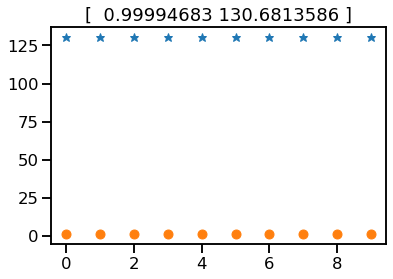

In [65]:
plt.plot(mask_beh_s[0:10], '*')
plt.plot(mask_test[1][0:10], 'o')
plt.title(spk2fsm)


In [18]:
"get only hit/miss trials & reset indices"
sub_df = beh_df[beh_df['hit_hist'] != 'viol']
sub_df.index = range(len(sub_df))

In [78]:
s[1], e[1]

(498.909227, 504.188223)

In [94]:
sub_df

,hit_hist,delay,pair_hist,correct_side,prev_side,aud1_sigma,aud2_sigma,c_poke,end_state,hit_state,aud1_on,aud1_off,aud2_on,aud2_off
0,hit,6,3,RIGHT,RIGHT,0.019683,0.007290,482.048223,491.384224,490.309221,482.098232,482.498223,488.499224,488.898223
1,miss,2,9,RIGHT,RIGHT,0.008904,0.007300,498.909227,504.188223,502.903229,498.960232,499.360221,501.359229,501.759230
2,hit,2,6,LEFT,RIGHT,0.002700,0.007290,505.471227,510.643223,509.341221,505.522228,505.922229,507.922222,508.321227
3,hit,4,10,RIGHT,LEFT,0.013248,0.007300,516.873222,524.213229,522.813226,516.923231,517.323241,521.324223,521.724223
4,miss,6,6,LEFT,RIGHT,0.002700,0.007290,530.486228,539.707221,538.269221,530.537227,530.937225,536.936230,537.336233
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301,hit,6,13,LEFT,RIGHT,0.004023,0.007300,5184.165229,5193.525236,5192.218219,5184.216224,5184.616224,5190.615234,5191.015235
302,hit,6,8,LEFT,LEFT,0.019683,0.053144,5200.459223,5209.354228,5208.175221,5200.509224,5200.909224,5206.909227,5207.309225
303,hit,2,2,RIGHT,LEFT,0.007290,0.002700,5227.210220,5232.558223,5231.212228,5227.260225,5227.660226,5229.661221,5230.061221
304,hit,2,12,LEFT,RIGHT,0.002704,0.007300,5241.322233,5246.522218,5245.159224,5241.373230,5241.773230,5243.773224,5244.173227


In [125]:
s = sub_df['c_poke']
e = sub_df['aud2_off']

trode = 1
cut_samples = []
trial_len = []
trial = []

for i in range(len(s)):

    idx_s = np.searchsorted(mask_beh_s, s[i], side = "left")
    idx_e = np.searchsorted(mask_beh_s, e[i], side = "left")
    
    trial_len.append(idx_e - idx_s)
    cut_samples.append(np.sum(mask_test[trode][idx_s:idx_e]))
    
#     print(idx_s, idx_e, trial_len, cut_samples)
#     trial.append()

[5251.93025604 5251.93028937 5251.9303227  ... 5254.78113779 5254.78117112
 5254.78120445]


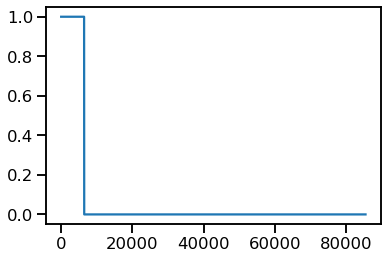

In [126]:
plt.plot(mask_test[1][idx_s:idx_e])
print(mask_beh_s[idx_s:idx_e])

(array([91., 78., 49., 47., 18., 10.,  3.,  4.,  5.,  1.]),
 array([    0. ,  5758.7, 11517.4, 17276.1, 23034.8, 28793.5, 34552.2,
        40310.9, 46069.6, 51828.3, 57587. ]),
 <BarContainer object of 10 artists>)

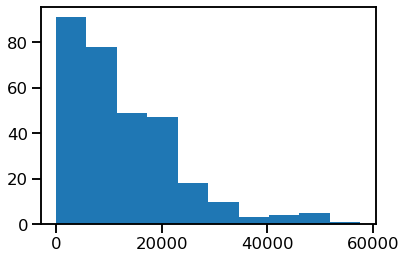

In [127]:
plt.hist(cut_samples)
# plt.hist(trial_len)

In [128]:
counter = 0
n_samples = 1
for i in range(len(cut_samples)):
    if cut_samples[i] < n_samples:
        counter+=1
print(counter)

70


# Plotting 2 second, L hit trials

In [99]:
"get_raster for all neurons and assigned events"

def get_neuron_rasters(neurons, events, windows, df):
    """
    This function can be used to get rasters for multiple neurons across multiple events
    with specific time windows for each event
    
    inputs:
    -------
    neurons : NeuroVis object, N neurons long
    events  : list, event name in strings from your behavior df you want to align to
    windows : list, time window in ms to grab for each event
    df      : behavior data frame with event information
    
    returns:
    -------
    neuron_rasters : list, raster dictionaries stored by [neuron][event] for plotting"""
    
    #initialize storage ([Neuron][Event])
    neuron_rasters = []  

    # iterate over each neuron and event
    for neuron in range(len(neurons)):
        
        rasters = []
        
        for event in range(len(events)):
            
        # create raster dictionary
            raster = neurons[neuron].get_raster(event = events[event], conditions=None, 
                                                df = df, window=windows[event], plot=False)
            rasters.append(raster)

        neuron_rasters.append(rasters)
    
    return neuron_rasters



In [107]:
beh_df_d2_hl.drop(index)

NameError: name 'index' is not defined

In [104]:
# filter dataframe
beh_df_d2_hl = beh_df[(beh_df['correct_side'] == 'LEFT') & (beh_df['delay'] == 2)
       & (beh_df['hit_hist'] == 'hit')]


# initilaize
events = ['c_poke', 'aud1_on', 'aud2_on', 'hit_state', 'aud1_on']
windows = [[-300,700], [-500,1000], [-500, 1000], [-500,1100], [-1000,2300]]

# create
# neuron_rasters = get_neuron_rasters(neurons, events, windows, df=beh_df_d2_hl)

In [101]:
def get_neuron_psths(neurons, events, windows, df):
    """
    This function can be used to get psths for multiple neurons across multiple events
    with specific time windows for each event
    
    inputs:
    -------
    neurons    : NeuroVis object, N neurons long
    events     : list, event name in strings from behavior df you want to align to
    df         : behavior data frame with event information
    conditions : str, condition namefrom behavior df to split by (e.g. hit Y/N)
    windows    : list, time window in ms to grab for each event
    binsize    : int, binsize in ms 
     
    returns:
    -------
    neuron_psths : list, psths dicts stored by [neuron][event] for plotting"""
    
    
    #initialize storage ([Neuron][Event])
    neuron_psths = []  

    # iterate over each neuron and event
    for neuron in range(len(neurons)):
        
        psths = []
        
        for event in range(len(events)):
            
        # create psth dictionary
        
            psth = neurons[neuron].get_psth(event=events[event], df=beh_df_d2_hl,
                          window=windows[event], binsize=50, plot=False,
                          event_name=events[event])
            
            psths.append(psth)

        neuron_psths.append(psths)
    
    return neuron_psths
    

In [102]:
neuron_psths = get_neuron_psths(neurons, events, windows, df=beh_df_d2_hl)

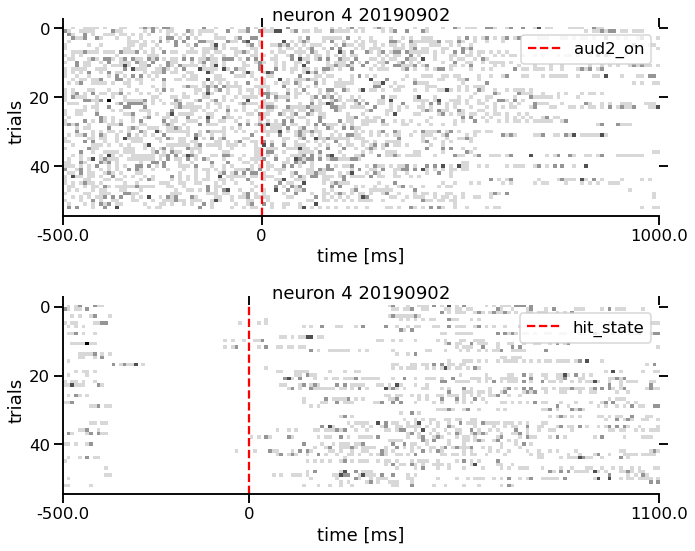

In [103]:
fig, ax = plt.subplots(2,1, figsize = (10,8))
nn = 3
cc = 2
neurons[nn].plot_raster(neuron_rasters[nn][cc], axis = ax[0], event_name=events[cc], cmap="Greys")
neurons[nn].plot_raster(neuron_rasters[nn][cc+1], axis = ax[1], event_name=events[cc+1], cmap="Greys")

# neurons[nn].plot_psth(neuron_psths[nn][cc],axis=ax[1], event_name=events[cc])

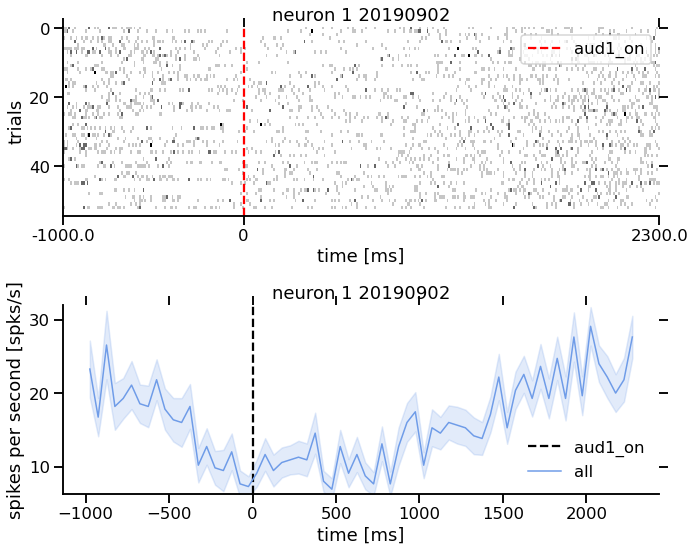

In [104]:
fig, ax = plt.subplots(2,1, figsize = (10,8))
nn = 0
cc = 4

# neurons[nn].plot_psth(neuron_psths[nn][cc],axis=ax[0], event_name=events[cc])
neurons[nn].plot_raster(neuron_rasters[nn][cc], axis = ax[0], event_name=events[cc], cmap="Greys")
neurons[nn].plot_psth(neuron_psths[nn][cc],axis=ax[1], event_name=events[cc])

## Rogue plots

In [140]:
neurons[0].name

'1 20190902'

IndexError: index 1 is out of bounds for axis 0 with size 1

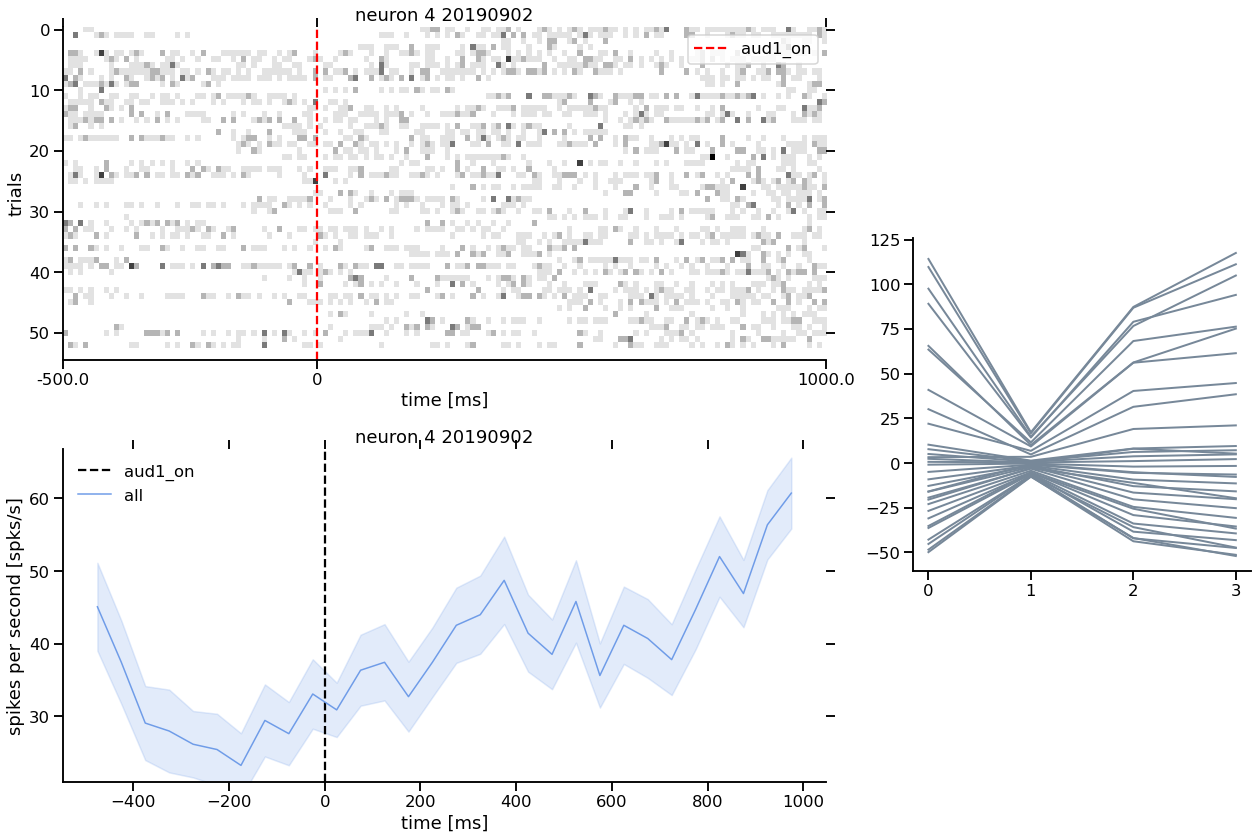

In [105]:
sns.set_context("talk")
fig = plt.figure(figsize=(18,12))
ax1 = plt.subplot2grid((4, 3), (0, 0), rowspan=2, colspan=2) 
ax2 = plt.subplot2grid((4, 3), (2, 0), rowspan=2, colspan=2)
ax3 = plt.subplot2grid((4, 3), (1, 2), rowspan=2, colspan=1)


nn = 3
cc = 1
wave_snippet = spks_dict['waves_mn']
n3 = wave_snippet[nn]

neurons[nn].plot_raster(neuron_rasters[nn][cc], axis = ax1, event_name=events[cc], cmap="Greys")
neurons[nn].plot_psth(neuron_psths[nn][cc],axis=ax2, event_name=events[cc])
for i in range(4):
    ax3.plot(n3[i],color = 'lightslategrey',lw=2)
    
ax3.set_title('Average Waveform')

save_name=neurons[0].name
fig.savefig('neuron1.jpeg')


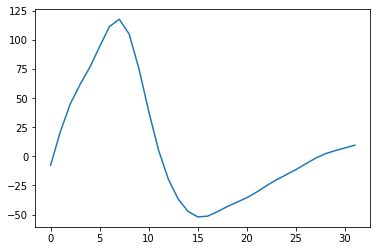

In [110]:
neuron_wave = wave_snippet[3]
plt.plot(neuron_wave[3])

In [158]:
"proof of cell"

# need to f/u w/ Tyler on these shapes

tt_num = 3
wave_snippet = spks_dict['waves_mn']
wave_snippet[3].shape



(4, 32)

In [ ]:
n_cells = len(spks_dict["event_ts_fsm"])
trode_num = spks_dict["trodenum"]
spk_qual = []
for cell in range(n_cells):
    if spks_dict["mua"][cell] == 1:
        spk_qual.append("multi")
    elif spks_dict["single"][cell] == 1:
        spk_qual.append("single")
    else:
        raise TypeError("cell not marked as multi or single")
n_cells, spk_qual, trode_num        